In [2]:
import sys
import os
import importlib

import numpy as np
import scipy
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt
from cycler import cycler

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
feature_colors = ["grey", "#E46C0A", "#51BD52", "#D85BD8", "#5AA5A5", "#0000FF", "#ffcc00"]

In [5]:
%load_ext autoreload
%autoreload 2

# Load data

In [6]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# distances to F161
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time

In [7]:
# only interacting salt bridges
sb_ids = [42, 47, 52, 53, 58, 59]
X = np.hstack((cv_arr, sb_arr[:, sb_ids], rf161_arr[:, 1:2]))
y = np.concatenate(qp_du)
print(X.shape, y.shape)

(4150115, 9) (4150115,)


In [8]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}-F161")

# LASSO

In [9]:
def run_lasso(data, q, alpha=0.1, fit_intercept=True):
    model = Lasso(alpha=alpha, fit_intercept=False)
    model.fit(data, q)
    recon = model.predict(data)
    beta = model.coef_
    intercept = model.intercept_
    score = model.score(data, q)
    return recon, beta, intercept, score

In [10]:
w_arr = np.concatenate(weights)
cutoff = 0.2
nsamp = 100000
# take points at transition region
mid_idx = ((y > cutoff) & (y < 1 - cutoff)).nonzero()[0]
# weight by committor value
mid_weight = w_arr[mid_idx] * y[mid_idx] * (1 - y[mid_idx])
mid_weight /= np.sum(mid_weight)
idx = np.random.choice(mid_idx, size=min(nsamp,len(mid_idx)), p=mid_weight, replace=False)
# inverse sigmoid transform
logit_q = np.log(y[idx] / (1 - y[idx]))
# apply standardization
std_scale = StandardScaler()
X_trans = std_scale.fit_transform(X[idx])

In [11]:
# compute coefficients as a function of regularization strength
coeffs_all = []
r2_all = []
for a in np.linspace(0.02, 0.30, 15):
    _, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=a, fit_intercept=False)
    coeffs_all.append(coeffs)
    r2_all.append(r2)

In [12]:
coeffs_all[0].nonzero()[0]

array([0, 1, 2, 3, 6, 7, 8])

In [13]:
names = []
names.append(feature_names[0])
names.append(feature_names[1])
for i in sb_ids:
    names.append(feature_names[i - 30 + 2])
names.append(feature_names[33])

In [14]:
names

['Translocation',
 'Rotation',
 'R226 C$_\\zeta$-D129 C$_\\gamma$',
 'R226 C$_\\zeta$-D186 C$_\\gamma$',
 'R229 C$_\\zeta$-E183 C$_\\delta$',
 'R229 C$_\\zeta$-D186 C$_\\gamma$',
 'R232 C$_\\zeta$-E183 C$_\\delta$',
 'R232 C$_\\zeta$-D186 C$_\\gamma$',
 'R226-F161']

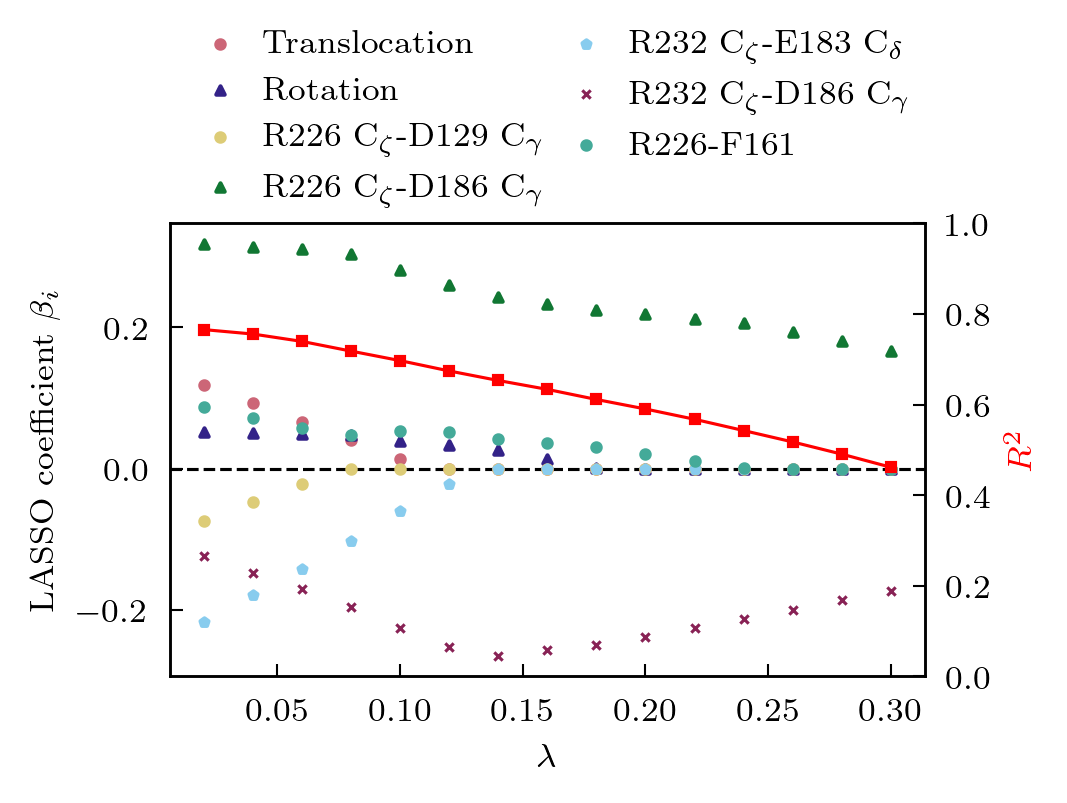

In [15]:
f = plt.figure(figsize=(3.25, 2), dpi=300)
ax = plt.gca()

ax2 = plt.twinx()
alphas = np.linspace(0.02, 0.30, 15)
ax2.plot(alphas, r2_all, '-s', color='r', zorder=1)
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.0, 1.0])

coeffs_all = np.array(coeffs_all)
cc = []
markers = list('o^D*px')
cc.append(dict(color=feature_colors[0], marker=markers[0]))
cc.append(dict(color=feature_colors[0], marker=markers[1]))
for i in range(1, 6):
    for j in range(6):
        cc.append(dict(color=feature_colors[i], marker=markers[j]))
for j in range(3):
    cc.append(dict(color=feature_colors[6], marker=markers[j]))

for i in coeffs_all[0].nonzero()[0]:
    ax.scatter(alphas, coeffs_all[:, i], marker=cc[i]['marker'], label=names[i])
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
# ax.set_ylim([-0.3, 0.2])
ax.axhline(ls="--", color='black', zorder=0)
pplt.legend(ncol=2, outside='top', ax=ax, borderpad=0, handletextpad=0.3)

([<matplotlib.axis.XTick at 0x7fb006a822b0>,
 [Text(0, 0, 'Translocation'),
  Text(1, 0, 'Rotation'),
  Text(2, 0, 'R226 C$_\\zeta$-D129 C$_\\gamma$'),
  Text(3, 0, 'R226 C$_\\zeta$-D186 C$_\\gamma$'),
  Text(4, 0, 'R229 C$_\\zeta$-E183 C$_\\delta$'),
  Text(5, 0, 'R229 C$_\\zeta$-D186 C$_\\gamma$'),
  Text(6, 0, 'R232 C$_\\zeta$-E183 C$_\\delta$'),
  Text(7, 0, 'R232 C$_\\zeta$-D186 C$_\\gamma$'),
  Text(8, 0, 'R226-F161')])

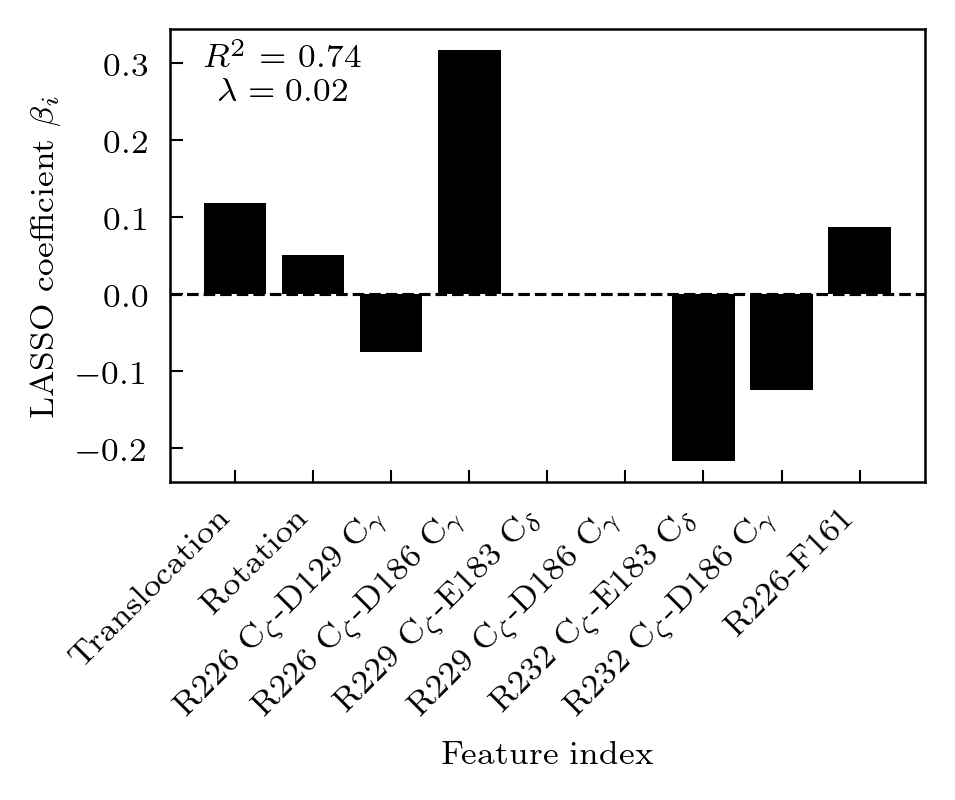

In [17]:
f = plt.figure(figsize=(3.25, 2), dpi=300)
ax = plt.gca()
ax.bar(np.arange(X.shape[-1]), coeffs_all[0], color='black', zorder=5)
ax.set_xlabel("Feature index")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
# ax.set_xlim([-1, 35])
# ax.set_ylim([-0.27, 0.17])
ax.axhline(color='black', zorder=0, ls='--')
pplt.text(0.15, 0.9, f"$R^2$ = {r2_all[2]:.2f}\n $\\lambda = 0.02$", ax=ax, transform=ax.transAxes)
plt.xticks(ticks=np.arange(0, 9), labels=names, rotation=45, ha='right')

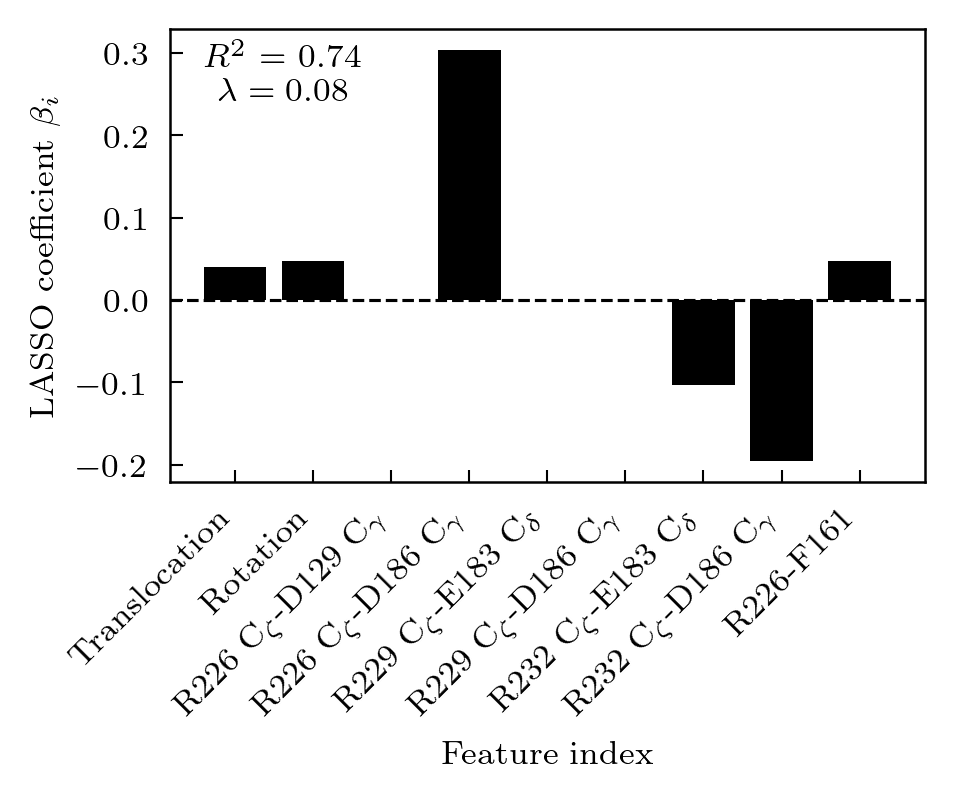

In [19]:
f = plt.figure(figsize=(3.25, 2), dpi=300)
ax = plt.gca()
ax.bar(np.arange(X.shape[-1]), coeffs_all[3], color='black', zorder=5)
ax.set_xlabel("Feature index")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
# ax.set_xlim([-1, 35])
# ax.set_ylim([-0.27, 0.17])
ax.axhline(color='black', zorder=0, ls='--')
pplt.text(0.15, 0.9, f"$R^2$ = {r2_all[2]:.2f}\n $\\lambda = {alphas[3]:.2f}$", ax=ax, transform=ax.transAxes)
ax.set_xticks(ticks=np.arange(0, 9), labels=names, rotation=45, ha='right')

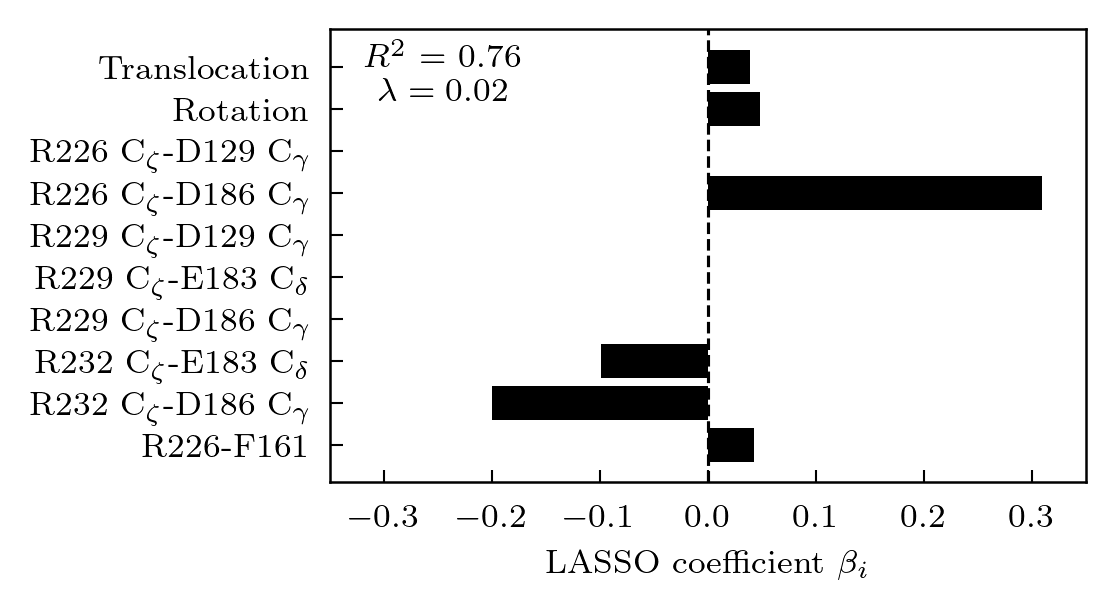

In [73]:
f = plt.figure(figsize=(3.25, 2), dpi=300)
ax = plt.gca()
ax.barh(np.arange(X.shape[-1]), coeffs_all[3], color='black', zorder=5)
ax.set_xlabel("LASSO coefficient $\\beta_i$")
# ax.set_ylabel("Feature index")
ax.set_xlim([-0.35, 0.35])
ax.axvline(color='black', zorder=0, ls='--')
pplt.text(0.15, 0.9, f"$R^2$ = {r2_all[2]:.2f}\n $\\lambda = {alphas[3]:.2f}$", ax=ax, transform=ax.transAxes)
ax.set_yticks(ticks=np.arange(0, 10), labels=names, ha='right')
ax.invert_yaxis()

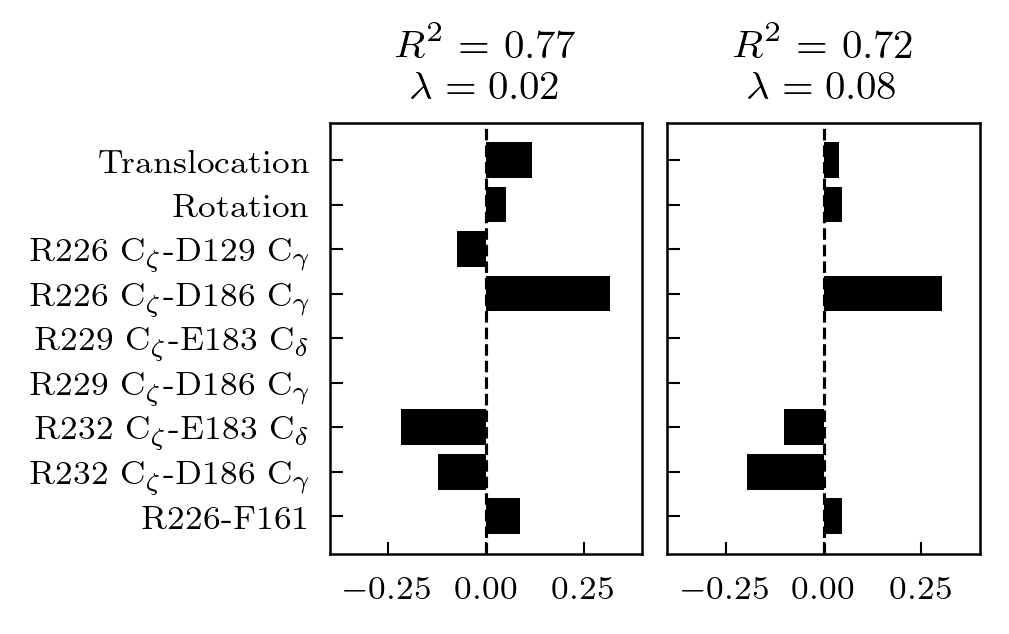

In [20]:
f, axs = plt.subplots(1, 2, figsize=(3.25, 2), dpi=300, sharex=True, sharey=True, constrained_layout=True)
axs[0].barh(np.arange(X.shape[-1]), coeffs_all[0], color='black', zorder=5)
axs[1].barh(np.arange(X.shape[-1]), coeffs_all[3], color='black', zorder=5)
    
axs[0].set_yticks(ticks=np.arange(0, 9), labels=names, ha='right')
axs[0].invert_yaxis()

alphas = np.linspace(0.02, 0.30, 15)
for ax, i in zip(axs, (0, 3)):
    # ax.set_xlabel("LASSO coefficient $\\beta_i$")
    ax.set_title(f"$R^2$ = {r2_all[i]:.2f}\n $\\lambda = {alphas[i]:.2f}$")
    # ax.set_ylabel("Feature index")
    ax.set_xlim([-0.4, 0.4])
    ax.axvline(color='black', zorder=0, ls='--')
    # pplt.text(0.15, 0.9, f"$R^2$ = {r2_all[i]:.2f}\n $\\lambda = {alphas[i]:.2f}$", ax=ax, transform=ax.transAxes)

# Split into down-> TS and TS->up

In [21]:
# X = np.hstack((cv_arr, sb_arr[:, 30:], rf161_arr))
# y = np.concatenate(qp_du)
print(X.shape, y.shape)

(4150115, 9) (4150115,)


In [37]:
# down -> TS
w_arr = np.concatenate(weights)
nsamp = 100000
# take points at transition region
low_idx = ((y > 0.) & (y <= 0.5)).nonzero()[0]
# weight by committor value
low_weight = w_arr[low_idx] * y[low_idx] * (1 - y[low_idx])
low_weight /= np.sum(low_weight)
idx = np.random.choice(low_idx, size=min(nsamp,len(low_idx)), p=low_weight, replace=False)
# inverse sigmoid transform
logit_q = np.log(2 * y[idx] / (1 - 2 * y[idx])) # scale to [0, 0.5]
# apply standardization
std_scale = StandardScaler()
X_trans = std_scale.fit_transform(X[idx])

In [38]:
# compute coefficients as a function of regularization strength
coeffs_all = []
r2_all = []
alphas = np.linspace(0.02, 0.2, 10)
for a in alphas:
    _, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=a, fit_intercept=False)
    coeffs_all.append(coeffs)
    r2_all.append(r2)

In [39]:
alphas

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ])

Text(0, 0.5, '$\\hat{q}_+$ (LASSO-predicted)')

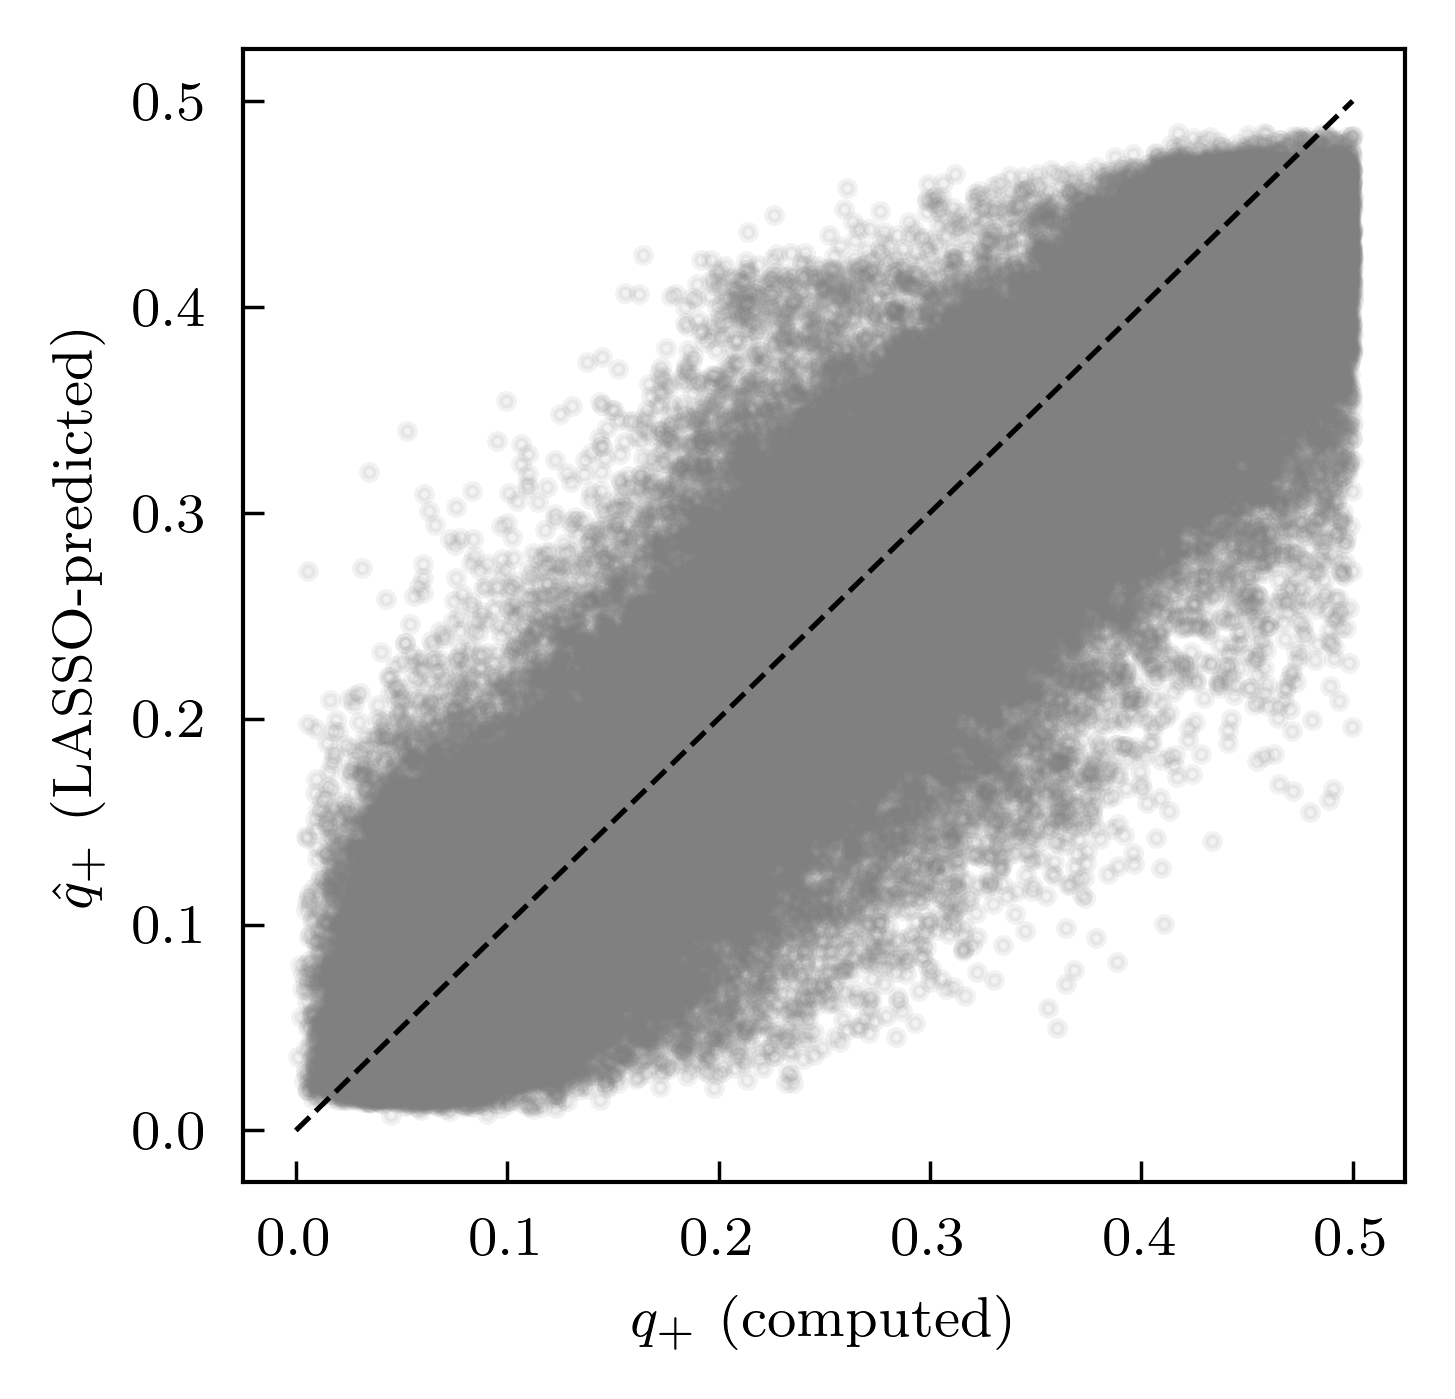

In [25]:
# plot correlation 
pred_logit = np.dot(X_trans, coeffs_all[0])
yhat = 0.5 / (1 + np.exp(-pred_logit))
f = plt.figure(figsize=(3., 3.), dpi=500)
ax = plt.gca()
ax.scatter(y[idx], yhat, alpha=0.1, c="gray")
ax.plot(np.linspace(0., 0.5, 100), np.linspace(0., 0.5, 100), 'k--')
# ax.set_xlim([0.2, 0.8])
# ax.set_ylim([0.2, 0.8])
ax.set_xlabel("$q_+$ (computed)")
ax.set_ylabel("$\hat{q}_+$ (LASSO-predicted)")
# pplt.text(0.1, 0.9, "

In [26]:
print(r2_all)

[0.7040700577259245, 0.6985391929067319, 0.6935100709159725, 0.6886512967394165, 0.6825755374059252, 0.6751521224587835, 0.6708297103808072, 0.6669192396749875, 0.6624871859153691, 0.6575335746439044]


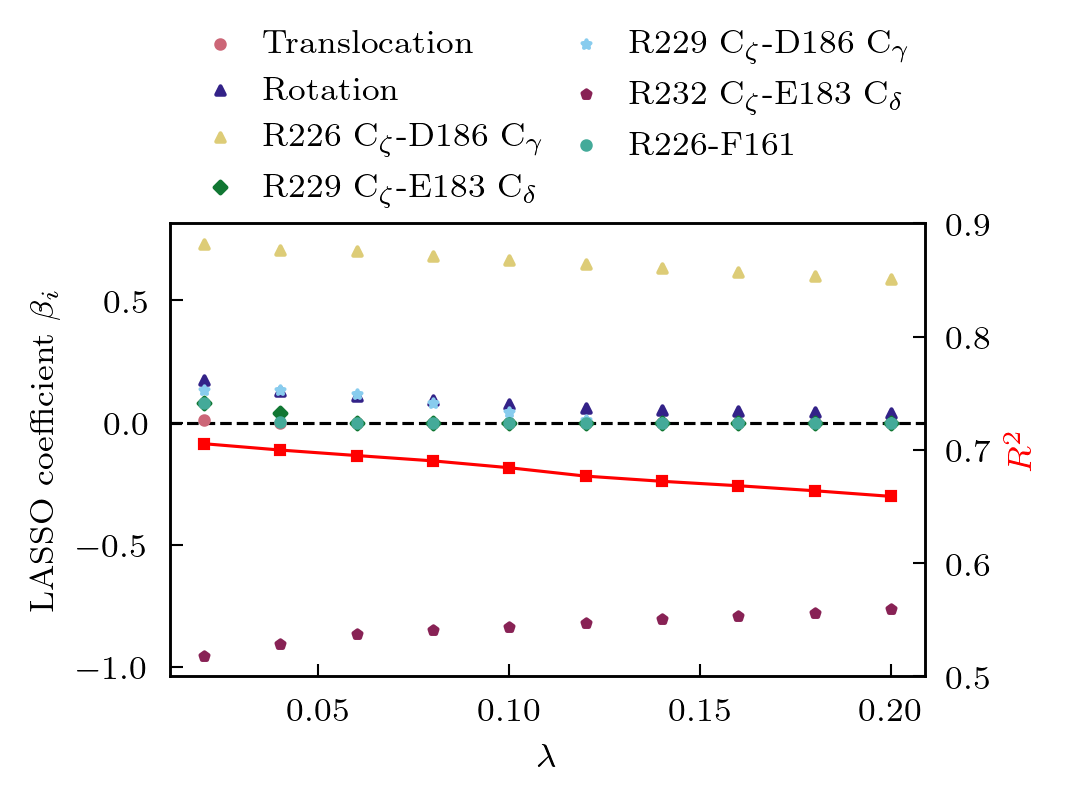

In [40]:
f = plt.figure(figsize=(3.25, 2), dpi=300)
ax = plt.gca()

ax2 = plt.twinx()

ax2.plot(alphas, r2_all, '-s', color='r', zorder=1)
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.5, 0.9])

coeffs_all = np.array(coeffs_all)
cc = []
markers = list('o^D*px')
cc.append(dict(color=feature_colors[0], marker=markers[0]))
cc.append(dict(color=feature_colors[0], marker=markers[1]))
for i in range(1, 6):
    for j in range(6):
        cc.append(dict(color=feature_colors[i], marker=markers[j]))
for j in range(3):
    cc.append(dict(color=feature_colors[6], marker=markers[j]))

for i in coeffs_all[0].nonzero()[0]:
    ax.scatter(alphas, coeffs_all[:, i], marker=cc[i]['marker'], label=names[i])
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
# ax.set_ylim([-0.3, 0.2])
ax.axhline(ls="--", color='black', zorder=0)
pplt.legend(ncol=2, outside='top', ax=ax, borderpad=0, handletextpad=0.3)

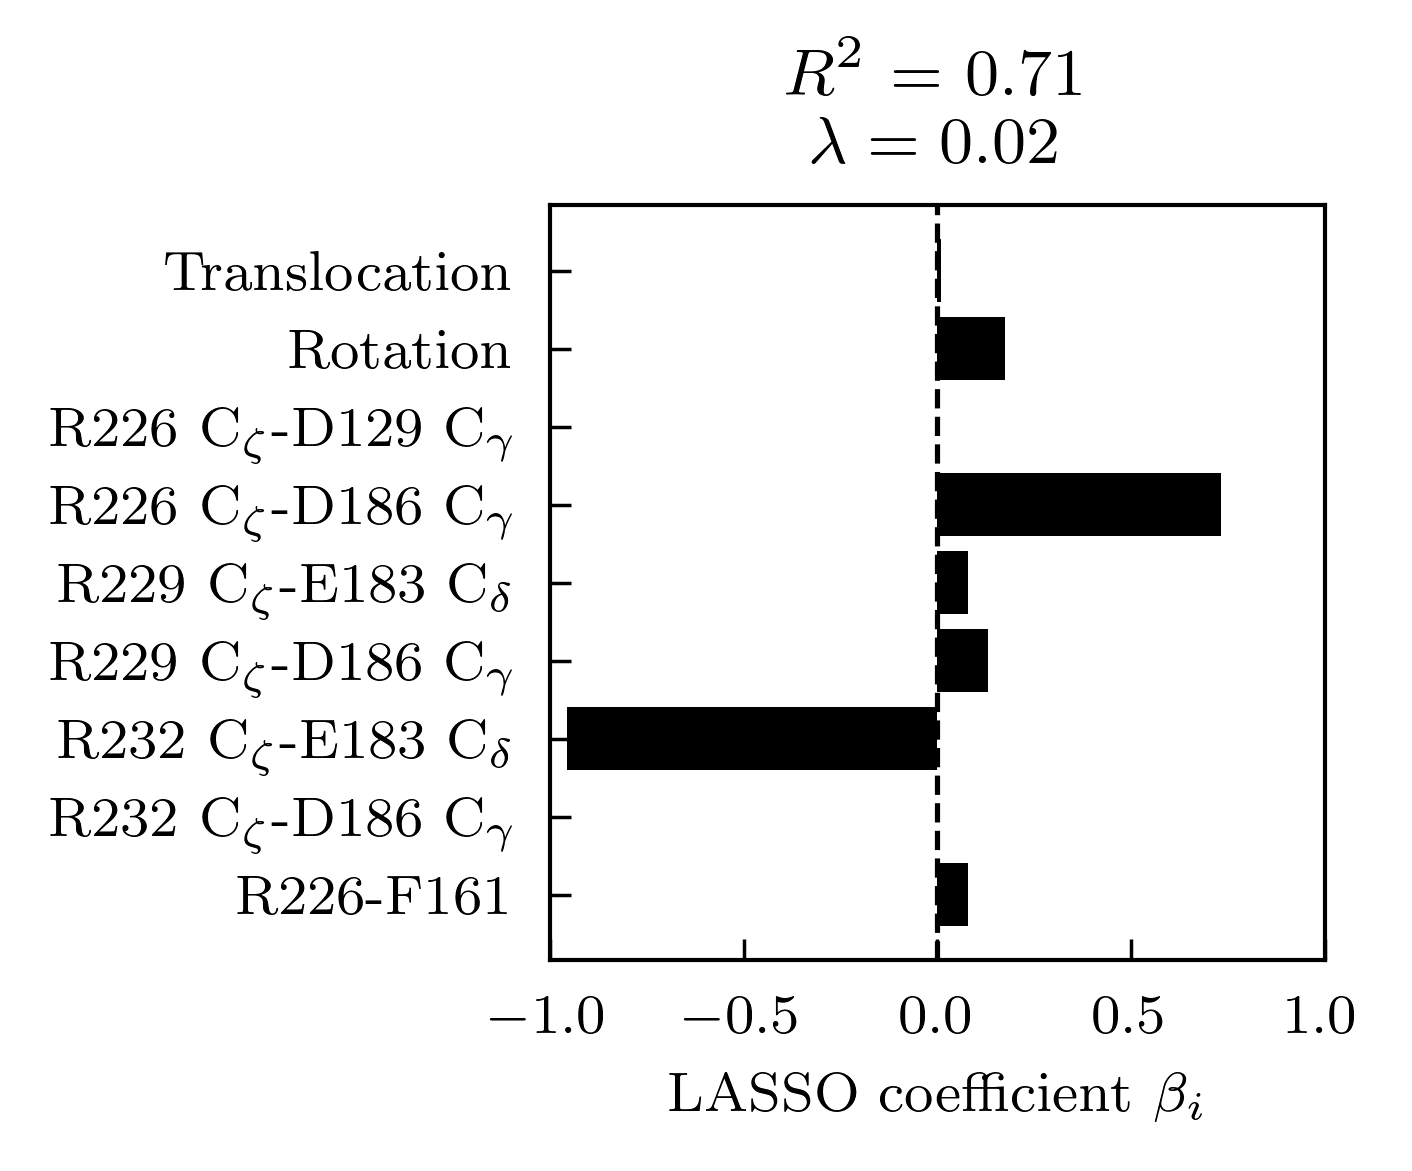

In [41]:
f = plt.figure(figsize=(2, 2), dpi=500)
ax = plt.gca()
ax.barh(np.arange(X.shape[-1]), coeffs_all[0], color='black', zorder=5)
ax.set_xlabel("LASSO coefficient $\\beta_i$")
# ax.set_ylabel("Feature index")
ax.set_xlim([-1, 1])
ax.axvline(color='black', zorder=0, ls='--')
plt.title(f"$R^2$ = {r2_all[0]:.2f}\n $\\lambda = {alphas[0]:.2f}$")
ax.set_yticks(ticks=np.arange(0, 9), labels=names, ha='right')
ax.invert_yaxis()

## UP

In [42]:
def sample_hi(lo, hi, nsamp, w_arr):
    hi_idx = ((y >= lo) & (y < hi)).nonzero()[0]
    # weight by committor value
    hi_weight = w_arr[hi_idx] * y[hi_idx] * (1 - y[hi_idx])
    hi_weight /= np.sum(hi_weight)
    idx = np.random.choice(hi_idx, size=min(nsamp,len(hi_idx)), p=hi_weight, replace=False)
    return idx

In [43]:
# down -> TS
w_arr = np.concatenate(weights)
nsamp = 100000
# take points at transition region
idx = sample_hi(0.5, 1.0, nsamp, w_arr)
# inverse sigmoid transform from [0.5, 1) -> (-inf, inf)
logit_q = np.log((2 * y[idx] - 1) / (2 - 2 * y[idx]))
# apply standardization
std_scale = StandardScaler()
X_trans = std_scale.fit_transform(X[idx])

In [44]:
# compute coefficients as a function of regularization strength
coeffs_all = []
r2_all = []
alphas = np.linspace(0.02, 0.20, 10)
for a in alphas:
    _, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=a, fit_intercept=False)
    coeffs_all.append(coeffs)
    r2_all.append(r2)

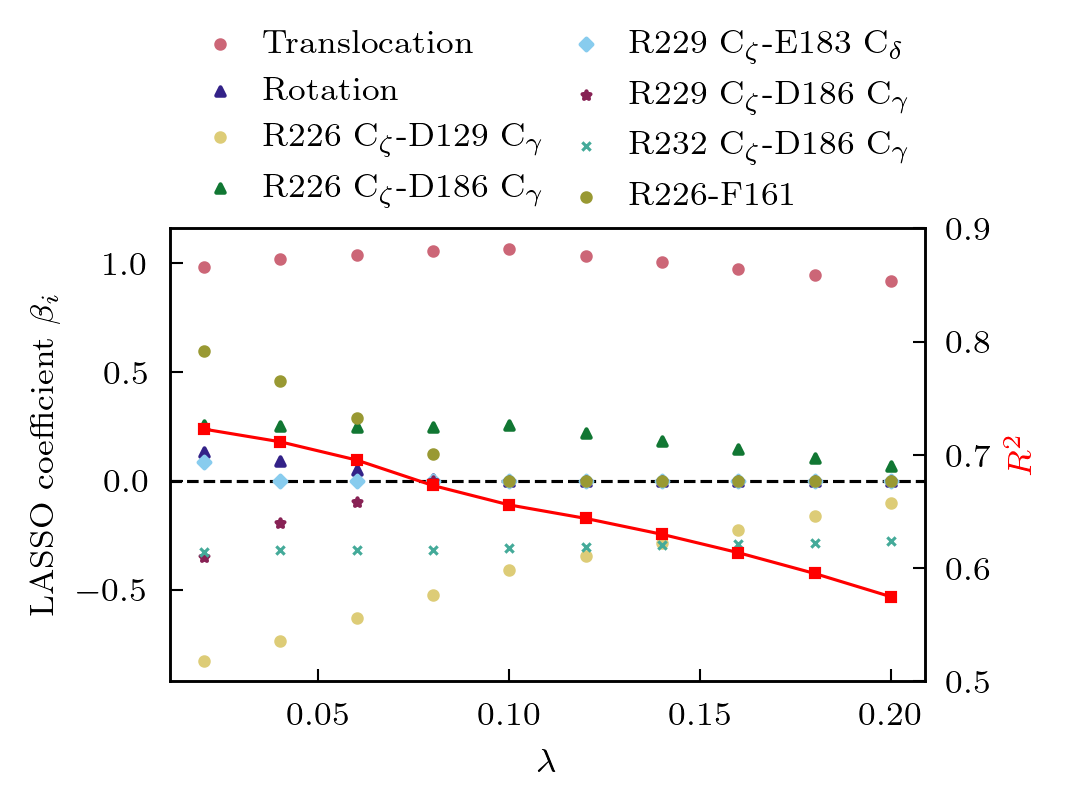

In [32]:
f = plt.figure(figsize=(3.25, 2), dpi=300)
ax = plt.gca()

ax2 = plt.twinx()

ax2.plot(alphas, r2_all, '-s', color='r', zorder=1)
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.5, 0.9])

coeffs_all = np.array(coeffs_all)
cc = []
markers = list('o^D*px')
cc.append(dict(color=feature_colors[0], marker=markers[0]))
cc.append(dict(color=feature_colors[0], marker=markers[1]))
for i in range(1, 6):
    for j in range(6):
        cc.append(dict(color=feature_colors[i], marker=markers[j]))
for j in range(3):
    cc.append(dict(color=feature_colors[6], marker=markers[j]))

for i in coeffs_all[0].nonzero()[0]:
    ax.scatter(alphas, coeffs_all[:, i], marker=cc[i]['marker'], label=names[i])
ax.set_xlabel("$\\lambda$")
ax.set_ylabel("LASSO coefficient $\\beta_i$")
# ax.set_ylim([-0.3, 0.2])
ax.axhline(ls="--", color='black', zorder=0)
pplt.legend(ncol=2, outside='top', ax=ax, borderpad=0, handletextpad=0.3)

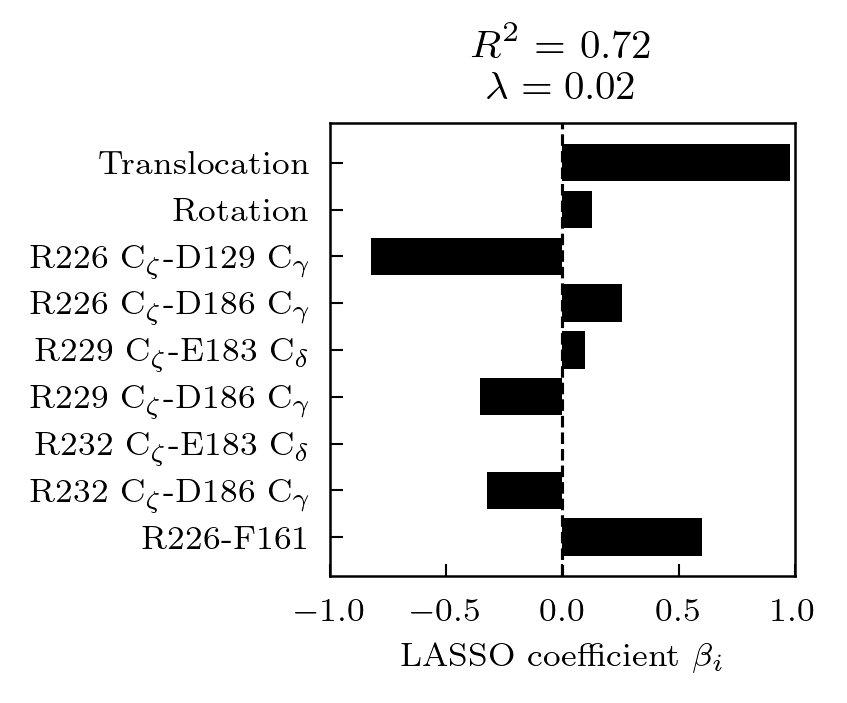

In [45]:
f = plt.figure(figsize=(2, 2), dpi=300)
ax = plt.gca()
ax.barh(np.arange(X.shape[-1]), coeffs_all[0], color='black', zorder=5)
ax.set_xlabel("LASSO coefficient $\\beta_i$")
# ax.set_ylabel("Feature index")
ax.set_xlim([-1, 1])
ax.axvline(color='black', zorder=0, ls='--')
plt.title(f"$R^2$ = {r2_all[0]:.2f}\n $\\lambda = {alphas[0]:.2f}$")
ax.set_yticks(ticks=np.arange(0, 9), labels=names, ha='right')
ax.invert_yaxis()

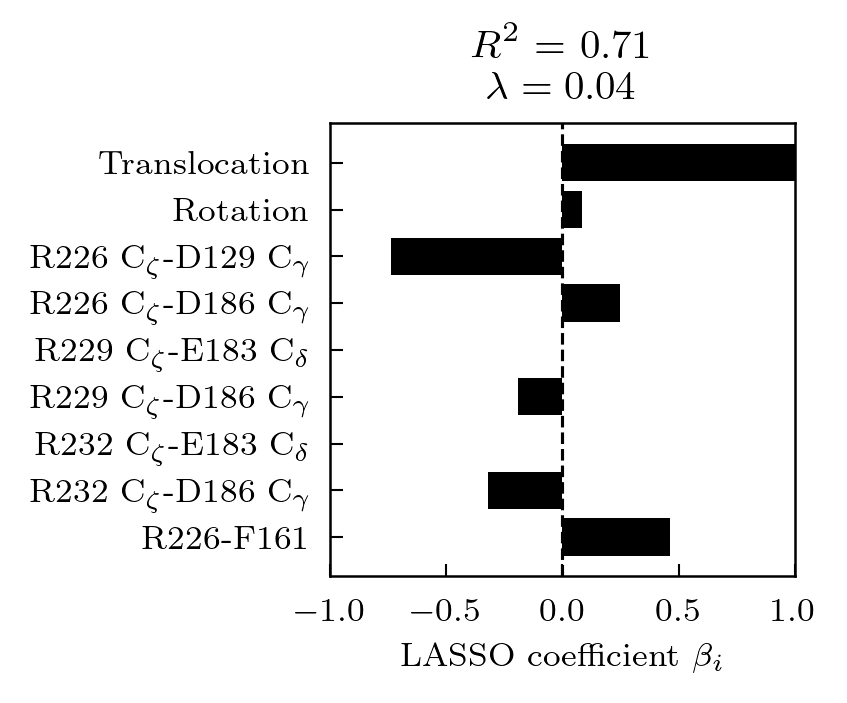

In [46]:
f = plt.figure(figsize=(2, 2), dpi=300)
ax = plt.gca()
ax.barh(np.arange(X.shape[-1]), coeffs_all[1], color='black', zorder=5)
ax.set_xlabel("LASSO coefficient $\\beta_i$")
# ax.set_ylabel("Feature index")
ax.set_xlim([-1, 1])
ax.axvline(color='black', zorder=0, ls='--')
plt.title(f"$R^2$ = {r2_all[1]:.2f}\n $\\lambda = {alphas[1]:.2f}$")
ax.set_yticks(ticks=np.arange(0, 9), labels=names, ha='right')
ax.invert_yaxis()